#### This juypter book is based on Hands-on Machine Learning with Scikit-Learn & Tensorflow by Aurelien Geron. This is for learning purpose.
### Autoencoders

Autoencoders are artificial neural networks capable of learning efficient representations of the input data, called codings, without any labelled training data. <br />
Autoencoders represent the features in lower dimensions making them useful wide variety of applications like<br />
<br />1. Dimensionality reduction
<br />2. Feature detectors
<br />3. Unsupervised learning
<br />4. Generate more data that looks very similar to the training data. (Generative models)<br /><br /> 
Autoencoders try to simply copy their inputs to ouputs but we constraint the network in a number of ways and make it difficult for the network to generate the output. This causes the network to find effiecient ways to represent the data. <br /><br />
An autoencoder is composed of two components: 
<br />1. an encoder or recognition network that converts the inputs to an internal representation
<br />2. a decoder or generative network that converts the internal representation to the outputs
<br />The cost function contains a recostruction loss that penalizes the model if the generated outputs are different from the inputs<br />

### PCA using Autoencoder
For example if there are 3 inputs and in the next layer there are two neurons (encoder) and in the final layer there are again three neurons (decoders) as there must be equal number of neurons in the inputs and outputs. In this the 3 inputs must be reduced to 2 neurons and the autoencoder is said to be undercomplete. This constraint causes the autoencoder to extract and represent features in lower dimensions and ignore unimportant features.
<br /><br />If activation functions are **linear** and the cost function in **Mean Squared Error (MSE)**, then autoencoder ends up performing **PCA**.

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import os
import sys
from sklearn.preprocessing import StandardScaler

def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

# To plot pretty figures
%matplotlib inline
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

def plot_image(image, shape=[28, 28]):
    plt.imshow(image.reshape(shape), cmap="Greys", interpolation="nearest")
    plt.axis("off")
    
def plot_multiple_images(images, n_rows, n_cols, pad=2):
    images = images - images.min()  # make the minimum == 0, so the padding looks white
    w,h = images.shape[1:]
    image = np.zeros(((w+pad)*n_rows+pad, (h+pad)*n_cols+pad))
    for y in range(n_rows):
        for x in range(n_cols):
            image[(y*(h+pad)+pad):(y*(h+pad)+pad+h),(x*(w+pad)+pad):(x*(w+pad)+pad+w)] = images[y*n_cols+x]
    plt.imshow(image, cmap="Greys", interpolation="nearest")
    plt.axis("off")

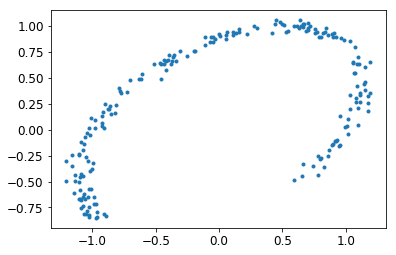

In [2]:
np.random.seed(4)
m = 200
w1, w2 = 0.1, 0.3
noise = 0.1

angles = np.random.rand(m) * 3 * np.pi / 2 - 0.5
data = np.empty((m, 3))
data[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * np.random.randn(m)/2
data[:, 1] = np.sin(angles) + 0.7 * noise * np.random.randn(m)/2
data[:, 2] = data[:, 0] * w1 + data[:, 1] * w2 + noise * np.random.randn(m)
plt.plot(data[:, 0], data[:, 1], '.')
plt.show()

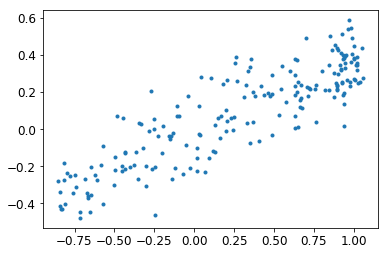

In [3]:
plt.plot(data[:, 1], data[:, 2], '.')
plt.show()

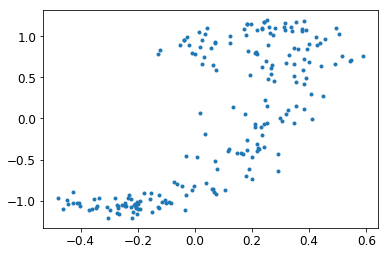

In [4]:
plt.plot(data[:, 2], data[:, 0], '.')
plt.show()

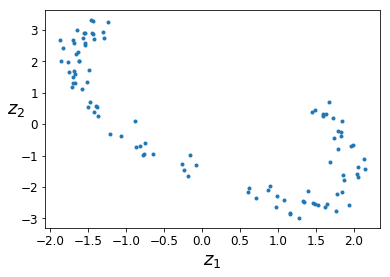

In [5]:
#Normalize the data

scaler = StandardScaler()
X_train = scaler.fit_transform(data[:100])
X_test = scaler.fit_transform(data[100:])

reset_graph()

n_inputs = 3
n_hidden = 2
n_outputs = n_inputs

learning_rate = 0.01

X = tf.placeholder(tf.float32, shape = [None, n_inputs])
hidden = tf.layers.dense(X, n_hidden)
outputs = tf.layers.dense(hidden, n_outputs)

reconstruction_loss = tf.reduce_mean(tf.square(outputs - X))

optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(reconstruction_loss)

init = tf.global_variables_initializer()
n_iterations = 1000
codings = hidden

with tf.Session() as sess:
    init.run()
    for iteration in range(n_iterations):
        training_op.run(feed_dict={X: X_train})
    codings_val = codings.eval(feed_dict={X: X_test})

plt.plot(codings_val[:,1], codings_val[:, 0], ".")
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18, rotation=0)
plt.show()